### Importing libraries

In [133]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

### Loading the data

In [152]:
train=pd.read_csv('Train.csv')
train.sample(5)

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
28943,train_id_28943,2016-12-12,TU 1759,PMO,TUN,2016-12-12 14:05:00,2016-12-12 14.50.00,DEP,UG AT7LBE,0.0
89160,train_id_89160,2018-10-03,TU 7041,PRG,DJE,2018-10-03 09:05:00,2018-10-03 11.45.00,ATA,TU 32AIML,0.0
78017,train_id_78017,2018-06-18,TU 0214,TUN,IST,2018-06-18 07:05:00,2018-06-18 09.40.00,ATA,TU 320IMU,45.0
81538,train_id_81538,2018-03-22,TU 0841,CKY,DSS,2018-03-22 20:10:00,2018-03-22 21.30.00,ATA,TU 320IMW,102.0
40382,train_id_40382,2017-05-07,TU 0719,ORY,TUN,2017-05-07 12:40:00,2017-05-07 15.05.00,ATA,TU 32AIMH,105.0


In [28]:
print('dimension of the dataset: ',train.shape)

dimension of the dataset:  (107833, 10)


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      107833 non-null  object 
 1   DATOP   107833 non-null  object 
 2   FLTID   107833 non-null  object 
 3   DEPSTN  107833 non-null  object 
 4   ARRSTN  107833 non-null  object 
 5   STD     107833 non-null  object 
 6   STA     107833 non-null  object 
 7   STATUS  107833 non-null  object 
 8   AC      107833 non-null  object 
 9   target  107833 non-null  float64
dtypes: float64(1), object(9)
memory usage: 8.2+ MB


In [29]:
train.describe()

,target
count,107833.000000
mean,48.733013
std,117.135562
min,0.000000
25%,0.000000
50%,14.000000
75%,43.000000
max,3451.000000


###   Data Preprocessing

In [153]:
train['FLTID']=train['FLTID'].astype('category')
train['DEPSTN']=train['DEPSTN'].astype('category')
train['ARRSTN']=train['ARRSTN'].astype('category')
train['STATUS']=train['STATUS'].astype('category')
train['AC']=train['AC'].astype('category')
train['DATOP']=pd.to_datetime(train['DATOP'])
train['STD']=pd.to_datetime(train['STD'])

In [154]:
train['STA']=train['STA'].map(lambda x:x.replace('.',':'))
train['STA']=pd.to_datetime(train['STA'])

In [137]:
train.dtypes

ID                object
DATOP     datetime64[ns]
FLTID           category
DEPSTN          category
ARRSTN          category
STD       datetime64[ns]
STA       datetime64[ns]
STATUS          category
AC              category
target           float64
dtype: object

In [155]:
train.insert(2,'FLTID_CAT',train['FLTID'].cat.codes)
train.insert(4,'DEPSTN_CAT',train['DEPSTN'].cat.codes)
train.insert(6,'ARRSTN_CAT',train['ARRSTN'].cat.codes)
train.insert(10,'STATUS_CAT',train['STATUS'].cat.codes)
train.insert(12,'AC_CAT',train['AC'].cat.codes)

In [156]:
train.sample(4)

,ID,DATOP,FLTID_CAT,FLTID,DEPSTN_CAT,DEPSTN,ARRSTN_CAT,ARRSTN,STD,STA,STATUS_CAT,STATUS,AC_CAT,AC,target
18658,train_id_18658,2016-08-03,104,TU 0262,81,MIR,109,SVO,2016-08-03 21:00:00,2016-08-04 00:50:00,0,ATA,41,TU 32AIMG,0.0
43051,train_id_43051,2017-05-30,229,TU 0711,123,TUN,31,CMN,2017-05-30 07:00:00,2017-05-30 09:40:00,0,ATA,45,TU 32AIMM,17.0
17314,train_id_17314,2016-04-13,289,TU 0902,123,TUN,81,MRS,2016-04-13 11:25:00,2016-04-13 13:00:00,0,ATA,36,TU 320IMW,59.0
84567,train_id_84567,2018-04-26,231,TU 0713,123,TUN,59,JED,2018-04-26 18:55:00,2018-04-26 23:10:00,0,ATA,35,TU 320IMV,11.0


In [166]:
r,p_value=stats.pearsonr(train.STATUS_CAT,train.target)
r

-0.15410878958408264

In [162]:
r

-0.07853615336311393

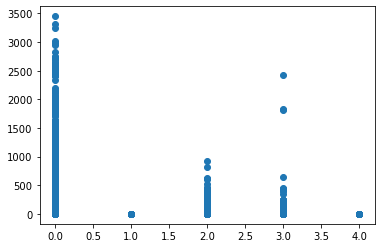

In [167]:
plt.scatter(train.STATUS_CAT,train.target)